# Amazon E-commerce Analytics (Portfolio)

**Role:** Data Analyst (Junior)

**Period in data:** 2022-03-31 → 2022-06-29

## Executive Summary
- Orders: **120,378** (cancelled: **17,185**, cancel rate: **14.28%**)
- Revenue (gross): **78,592,678.30 INR**
- Revenue (net, excluding cancelled): **71,673,394.00 INR**
- Average order value (net): **694.56 INR**
- Top revenue categories: **Set, kurta, Western Dress**


## Business Questions
1. What are the core KPIs (orders, revenue, AOV, cancellation rate)?
2. How does revenue change by month?
3. Which categories/products drive revenue?
4. Which regions (states/cities) generate the most revenue?
5. How do promotions and fulfilment types affect AOV?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'amazon_sales_clean.csv'
df = pd.read_csv(path, low_memory=False)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.shape

(128975, 27)

## 1) KPI Overview

In [2]:
orders_total = df['order_id'].nunique()
orders_cancelled = df['is_cancelled'].sum()
cancel_rate = orders_cancelled / orders_total

revenue_gross = df['amount'].sum()
revenue_net = df.loc[~df['is_cancelled'], 'amount'].sum()

aov_gross = revenue_gross / orders_total
aov_net = revenue_net / (orders_total - orders_cancelled)

pd.DataFrame({
    'metric':['orders_total','orders_cancelled','cancel_rate','revenue_gross','revenue_net','aov_gross','aov_net'],
    'value':[orders_total, int(orders_cancelled), round(cancel_rate,4), round(revenue_gross,2), round(revenue_net,2), round(aov_gross,2), round(aov_net,2)]
})


,metric,value
0,orders_total,1.203780e+05
1,orders_cancelled,1.833200e+04
2,cancel_rate,1.523000e-01
3,revenue_gross,7.859268e+07
4,revenue_net,7.167339e+07
5,aov_gross,6.528800e+02
6,aov_net,7.023600e+02


## 2) Monthly Revenue Trend (net)

In [3]:
net = df[~df['is_cancelled']].copy()
# order-level net revenue (sum by order)
orders = net.groupby('order_id').agg(order_date=('date','min'), month=('month','min'), revenue=('amount','sum'), units=('qty','sum')).reset_index()

monthly = orders.groupby('month').agg(
    orders=('order_id','nunique'),
    revenue=('revenue','sum'),
    units=('units','sum')
).reset_index().sort_values('month')

monthly['aov'] = (monthly['revenue']/monthly['orders']).round(2)
monthly


,month,orders,revenue,units,aov
0,2022-03,140,94810.0,152,677.21
1,2022-04,39132,26234520.0,42096,670.41
2,2022-05,33737,23953534.0,36269,710.01
3,2022-06,30184,21390530.0,32475,708.67


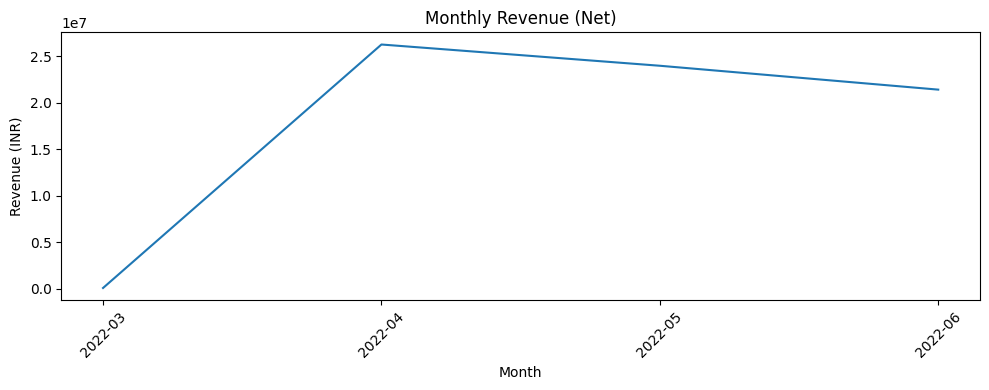

In [4]:
plt.figure(figsize=(10,4))
plt.plot(monthly['month'], monthly['revenue'])
plt.xticks(rotation=45)
plt.title('Monthly Revenue (Net)')
plt.xlabel('Month')
plt.ylabel('Revenue (INR)')
plt.tight_layout()
plt.show()


## 3) Category Performance (net)

In [5]:
cat = net.groupby('category').agg(
    revenue=('amount','sum'),
    units=('qty','sum'),
    orders=('order_id','nunique')
).sort_values('revenue', ascending=False)

cat.head(10)


,revenue,units,orders
category,,,
Set,35731673.0,43033,40855
kurta,19425870.0,42792,39743
Western Dress,10209590.0,13418,12924
Top,4904066.0,9368,8924
Ethnic Dress,732744.0,1016,1004
Blouse,418389.0,831,784
Bottom,135453.0,384,356
Saree,114694.0,147,123
Dupatta,915.0,3,2


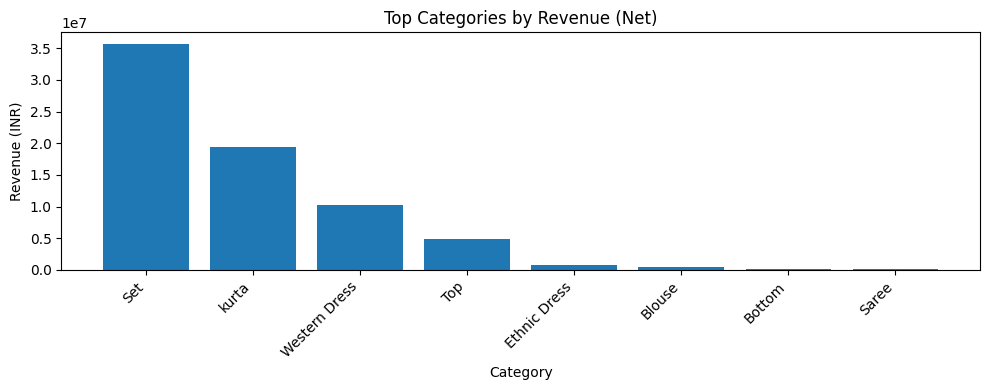

In [6]:
top_cat = cat.head(8).copy()
plt.figure(figsize=(10,4))
plt.bar(top_cat.index.astype(str), top_cat['revenue'])
plt.xticks(rotation=45, ha='right')
plt.title('Top Categories by Revenue (Net)')
plt.xlabel('Category')
plt.ylabel('Revenue (INR)')
plt.tight_layout()
plt.show()


## 5) Promo impact (AOV promo vs non-promo)

In [8]:
promo = orders.merge(net.groupby('order_id')['has_promo'].max().reset_index(), on='order_id', how='left')
promo_stats = promo.groupby('has_promo').agg(
    orders=('order_id','nunique'),
    revenue=('revenue','sum')
)
promo_stats['aov'] = (promo_stats['revenue']/promo_stats['orders']).round(2)
promo_stats


,orders,revenue,aov
has_promo,,,
False,30000,18087683.0,602.92
True,73193,53585711.0,732.12


## 6) Fulfilment impact (AOV)

In [9]:
fulfil = orders.merge(net.groupby('order_id')['fulfilment'].first().reset_index(), on='order_id', how='left')
fulfil_stats = fulfil.groupby('fulfilment').agg(
    orders=('order_id','nunique'),
    revenue=('revenue','sum')
)
fulfil_stats['aov'] = (fulfil_stats['revenue']/fulfil_stats['orders']).round(2)
fulfil_stats.sort_values('revenue', ascending=False)


,orders,revenue,aov
fulfilment,,,
Amazon,73199,50593039.0,691.17
Merchant,29994,21080355.0,702.82


## Insights & Recommendations
- **Cancellation rate ~14%** → monitor reasons, reduce cancellations and shipping exceptions.
- Revenue is concentrated in a few categories (Set, kurta, Western Dress) → prioritize inventory and merchandising.
- **Promoted orders show higher AOV** → validate promo ROI and scale best-performing campaigns.
- Top states contribute large revenue share → focus logistics SLAs and regional marketing.

## Next Steps
- Add profit/COGS to compute margin and contribution.
- Build a weekly automated KPI report.
- Create a simple cohort-retention if customer identifiers become available.